Num GPUs Available:  0
Step 1 (Load Dataset) completed in 19.74 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\114917319.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})


Step 2 (Filter Target Column) completed in 0.43 seconds
Step 3 (Separate Features and Target) completed in 0.16 seconds
Step 4 (Preprocess Data) completed in 4.88 seconds
Step 5 (Random Oversampling) completed in 0.44 seconds
Step 6 (Train-Test Split) completed in 0.97 seconds
Step 7 (Convert to Dense) completed in 0.66 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 8 (Define Neural Network) completed in 0.22 seconds
Epoch 1/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.6445 - loss: 0.6333 - val_accuracy: 0.6550 - val_loss: 0.6188
Epoch 2/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.6537 - loss: 0.6210 - val_accuracy: 0.6563 - val_loss: 0.6189
Epoch 3/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.6552 - loss: 0.6195 - val_accuracy: 0.6566 - val_loss: 0.6184
Epoch 4/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.6560 - loss: 0.6189 - val_accuracy: 0.6570 - val_loss: 0.6166
Epoch 5/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.6563 - loss: 0.6182 - val_accuracy: 0.6575 - val_loss: 0.6170
Epoch 6/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.6562 - loss: 0.6178 - val_accuracy: 0.6573 - val_loss: 0.6162
Epoch 7/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.6566 - loss: 0.6175 - val_accuracy: 0.6578 - val_loss: 0.6165
Epoch 8/30
2

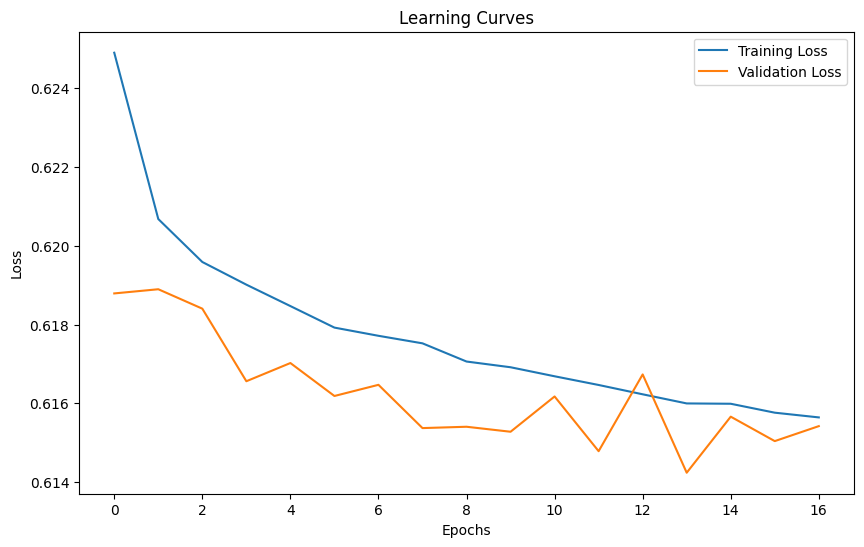

Step 11 (Plot Learning Curves) completed in 0.43 seconds
Model saved as 'loan_default_model.h5'
Step 12 (Save Model) completed in 0.08 seconds


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Verify GPU Availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Use more efficient loading options
df = pd.read_csv(csv_file_name, usecols=[
    'fico_range_low', 'fico_range_high', 'dti', 'annual_inc', 'revol_bal',
    'revol_util', 'total_acc', 'delinq_2yrs', 'pub_rec', 'loan_amnt',
    'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'purpose', 'emp_length', 'home_ownership', 'verification_status', 'loan_status'
], low_memory=False)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Separate features and target variable
start_time = time.time()
X = filtered_df.drop(columns=['loan_status'])
y = filtered_df['loan_status']
print(f"Step 3 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 4 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Apply Random Oversampling to balance the dataset
start_time = time.time()
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 5 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 6 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 7 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Define the neural network
start_time = time.time()
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 8 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 8: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 9 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 10 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 10: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 11 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 12 (Save Model) completed in {time.time() - start_time:.2f} seconds")


In [ ]:

# Step 8: Define the neural network
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])

# Step 9: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)

# Step 10: Evaluate the model
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 11: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Save the model
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")


In [22]:
import zipfile
import pandas as pd

# Unzip and load the dataset to explore available columns
# zip_file_path = r"first_10k_rows.zip"
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# # Extract and load the CSV file from the zip
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(".")

# Load the dataset into a DataFrame to examine all available columns
df = pd.read_csv(csv_file_name)

# Selected columns to analyze
selected_columns = [
    'earliest_cr_line',  # To derive credit history length
    'inq_last_6mths',    # Number of inquiries in the last 6 months
    'mths_since_last_delinq',  # Months since last delinquency
    'open_acc',          # Number of open credit lines
    'total_rec_late_fee' # Total amount of late fees received
]

# Check how many non-null values are present in each selected column
for column in selected_columns:
    non_null_count = df[column].notnull().sum()
    print(f"Column '{column}' has {non_null_count} non-null values out of {len(df)} total rows.")

C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3043281972.py:13: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Column 'earliest_cr_line' has 2104484 non-null values out of 2104542 total rows.
Column 'inq_last_6mths' has 2104483 non-null values out of 2104542 total rows.
Column 'mths_since_last_delinq' has 1022141 non-null values out of 2104542 total rows.
Column 'open_acc' has 2104484 non-null values out of 2104542 total rows.
Column 'total_rec_late_fee' has 2104513 non-null values out of 2104542 total rows.


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1071545001.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 39.88 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1071545001.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1071545001.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')


Step 2 (Filter Target Column) completed in 1.71 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1071545001.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1071545001.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months


Step 3 (Derive Credit History Length) completed in 0.29 seconds
Step 4 (Separate Features and Target) completed in 0.19 seconds
Step 5 (Preprocess Data) completed in 3.78 seconds
Step 6 (Random Oversampling) completed in 0.48 seconds
Step 7 (Train-Test Split) completed in 0.98 seconds
Step 8 (Convert to Dense) completed in 0.13 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.31 seconds
Epoch 1/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.6485 - loss: 0.6283 - val_accuracy: 0.6607 - val_loss: 0.6103
Epoch 2/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.6594 - loss: 0.6135 - val_accuracy: 0.6615 - val_loss: 0.6089
Epoch 3/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.6607 - loss: 0.6120 - val_accuracy: 0.6622 - val_loss: 0.6083
Epoch 4/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.6604 - loss: 0.6116 - val_accuracy: 0.6629 - val_loss: 0.6080
Epoch 5/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.6606 - loss: 0.6115 - val_accuracy: 0.6626 - val_loss: 0.6081
Epoch 6/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.6604 - loss: 0.6107 - val_accuracy: 0.6606 - val_loss: 0.6102
Epoch 7/30
20409/20409 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.6620 - loss: 0.6098 - val_accuracy: 0.6631 - val_loss: 0.6084
Step 10 (Tra

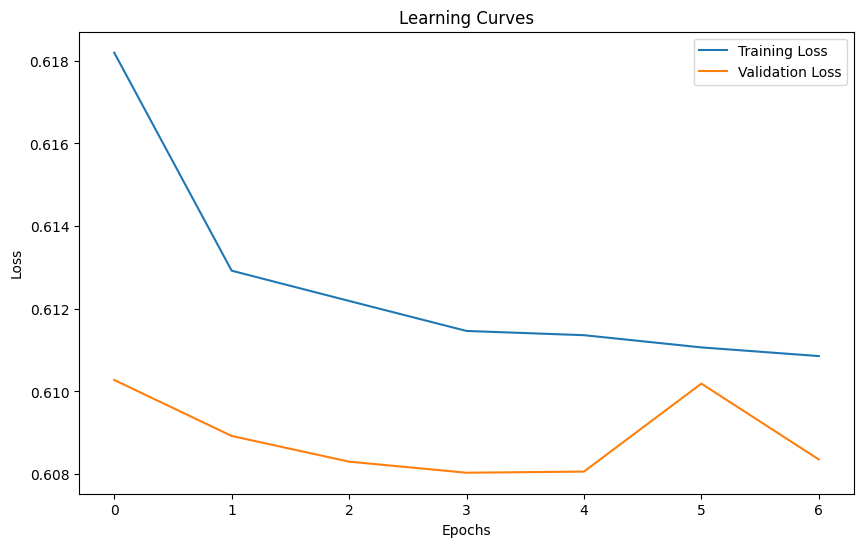

Step 12 (Plot Learning Curves) completed in 0.15 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.08 seconds


In [24]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'loan_amnt', 'term', 'annual_inc', 'dti', 'revol_bal',
    'fico_range_low', 'fico_range_high', 'credit_history_length',
    'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
    'total_rec_late_fee', 'emp_length', 'purpose', 'verification_status'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply Random Oversampling to balance the dataset
start_time = time.time()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 6 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define the neural network
start_time = time.time()
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3400781095.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 39.78 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3400781095.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3400781095.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')


Step 2 (Filter Target Column) completed in 2.29 seconds
Step 3 (Derive Credit History Length) completed in 0.24 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3400781095.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\3400781095.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months


Step 4 (Separate Features and Target) completed in 0.21 seconds
Step 5 (Preprocess Data) completed in 3.80 seconds
Step 6 (Random Oversampling) completed in 0.44 seconds
Step 7 (Train-Test Split) completed in 1.03 seconds
Step 8 (Convert to Dense) completed in 0.12 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.22 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6437 - loss: 0.6355 - val_accuracy: 0.6608 - val_loss: 0.6106
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6589 - loss: 0.6133 - val_accuracy: 0.6616 - val_loss: 0.6086
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.6604 - loss: 0.6116 - val_accuracy: 0.6611 - val_loss: 0.6098
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6606 - loss: 0.6111 - val_accuracy: 0.6617 - val_loss: 0.6082
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6607 - loss: 0.6113 - val_accuracy: 0.6627 - val_loss: 0.6085
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6606 - loss: 0.6102 - val_accuracy: 0.6628 - val_loss: 0.6087
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6611 - loss: 0.6105 - val_accuracy: 0.6621 - val_loss: 0.6079
Epoch 8/50
1

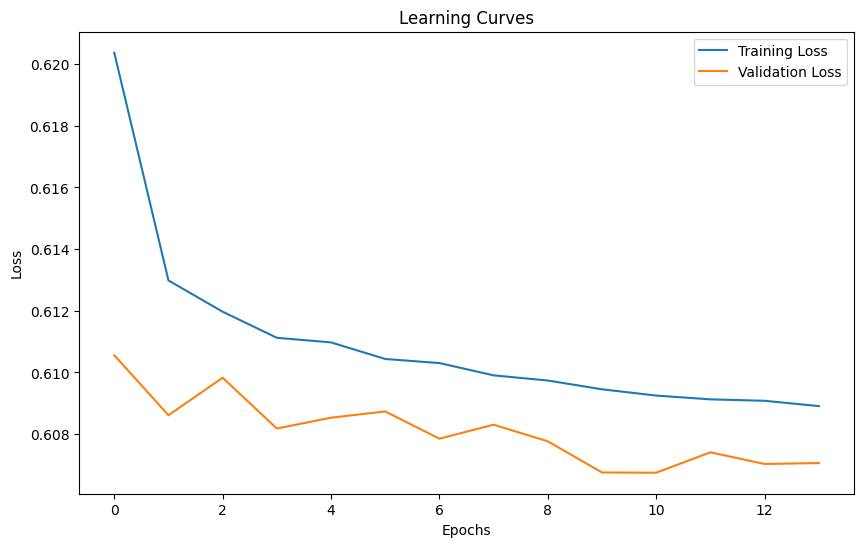

Step 12 (Plot Learning Curves) completed in 0.12 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.08 seconds


In [27]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'loan_amnt', 'term', 'annual_inc', 'dti', 'revol_bal',
    'fico_range_low', 'fico_range_high', 'credit_history_length',
    'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
    'total_rec_late_fee', 'emp_length', 'purpose', 'verification_status'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply Random Oversampling to balance the dataset
start_time = time.time()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 6 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define the optimized neural network
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


In [ ]:
['annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'loan_status',
'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status']


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1688814329.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 43.74 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1688814329.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1688814329.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1688814329.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Step 2 (Filter Target Column) completed in 2.38 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1688814329.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months


Step 3 (Derive Credit History Length) completed in 0.25 seconds
Step 4 (Separate Features and Target) completed in 0.31 seconds
Step 5 (Preprocess Data) completed in 6.85 seconds
Step 6 (Random Oversampling) completed in 0.44 seconds
Step 7 (Train-Test Split) completed in 0.97 seconds
Step 8 (Convert to Dense) completed in 0.81 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.25 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6584 - loss: 0.6199 - val_accuracy: 0.6754 - val_loss: 0.5971
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.6724 - loss: 0.6006 - val_accuracy: 0.6762 - val_loss: 0.5957
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.6749 - loss: 0.5983 - val_accuracy: 0.6771 - val_loss: 0.5958
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6753 - loss: 0.5977 - val_accuracy: 0.6766 - val_loss: 0.5947
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6768 - loss: 0.5964 - val_accuracy: 0.6764 - val_loss: 0.5944
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.6772 - loss: 0.5956 - val_accuracy: 0.6782 - val_loss: 0.5933
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.6765 - loss: 0.5961 - val_accuracy: 0.6773 - val_loss: 0.5940
Epoch 8/50
1

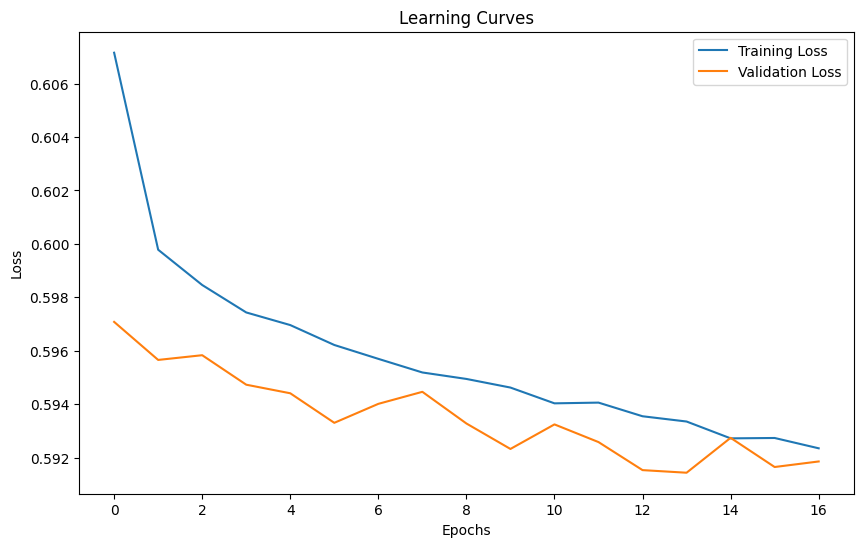

Step 12 (Plot Learning Curves) completed in 0.19 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.09 seconds


In [29]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = ['annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status']

X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply Random Oversampling to balance the dataset
start_time = time.time()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 6 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define the optimized neural network
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\4037871394.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 42.67 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\4037871394.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\4037871394.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')


Step 2 (Filter Target Column) completed in 2.29 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\4037871394.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\4037871394.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months


Step 3 (Derive Credit History Length) completed in 0.27 seconds
Step 4 (Separate Features and Target) completed in 0.31 seconds
Step 5 (Preprocess Data) completed in 7.38 seconds
Step 6 (Random Oversampling) completed in 0.42 seconds
Step 7 (Train-Test Split) completed in 0.93 seconds
Step 8 (Convert to Dense) completed in 1.15 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.58 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.6756 - loss: 0.5901 - val_accuracy: 0.6936 - val_loss: 0.5629
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.6908 - loss: 0.5673 - val_accuracy: 0.6945 - val_loss: 0.5618
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.6927 - loss: 0.5652 - val_accuracy: 0.6942 - val_loss: 0.5610
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.6933 - loss: 0.5645 - val_accuracy: 0.6956 - val_loss: 0.5643
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.6940 - loss: 0.5634 - val_accuracy: 0.6964 - val_loss: 0.5599
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.6946 - loss: 0.5625 - val_accuracy: 0.6965 - val_loss: 0.5616
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.6949 - loss: 0.5621 - val_accuracy: 0.6972 - val_loss: 0.5589
Epoch 8/50
1

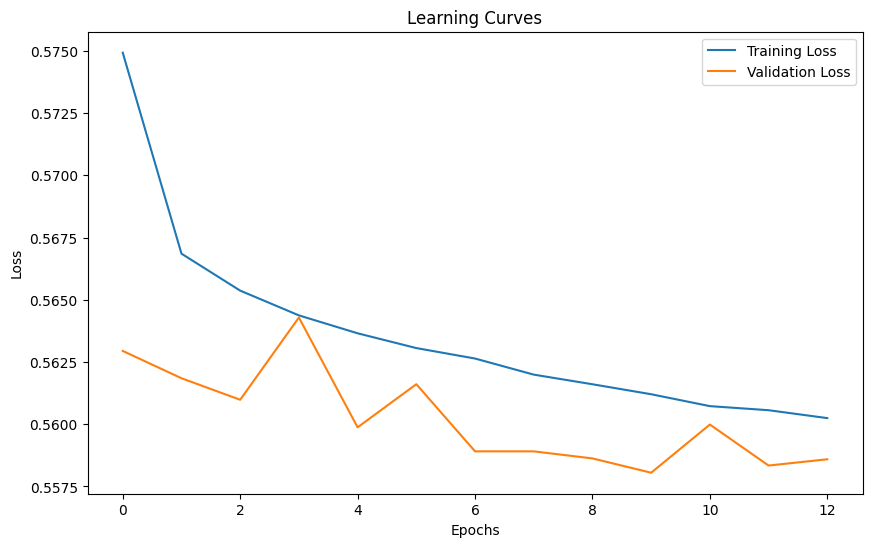

Step 12 (Plot Learning Curves) completed in 0.16 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.09 seconds


In [32]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply Random Oversampling to balance the dataset
start_time = time.time()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 6 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define the optimized neural network
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1499480936.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 48.84 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1499480936.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1499480936.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_31316\1499480936.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Step 2 (Filter Target Column) completed in 5.31 seconds
Step 3 (Derive Credit History Length) completed in 0.20 seconds
Step 4 (Separate Features and Target) completed in 0.29 seconds
Step 5 (Preprocess Data) completed in 7.94 seconds
Step 6 (Random Oversampling) completed in 0.62 seconds
Step 7 (Train-Test Split) completed in 1.22 seconds
Step 8 (Convert to Dense) completed in 2.88 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.27 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6781 - loss: 0.5892 - val_accuracy: 0.6912 - val_loss: 0.5644
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6908 - loss: 0.5661 - val_accuracy: 0.6937 - val_loss: 0.5632
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6922 - loss: 0.5646 - val_accuracy: 0.6947 - val_loss: 0.5625
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6932 - loss: 0.5639 - val_accuracy: 0.6949 - val_loss: 0.5615
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6923 - loss: 0.5636 - val_accuracy: 0.6945 - val_loss: 0.5618
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6938 - loss: 0.5630 - val_accuracy: 0.6960 - val_loss: 0.5607
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6949 - loss: 0.5619 - val_accuracy: 0.6955 - val_loss: 0.5610
Epoch 8/50
1

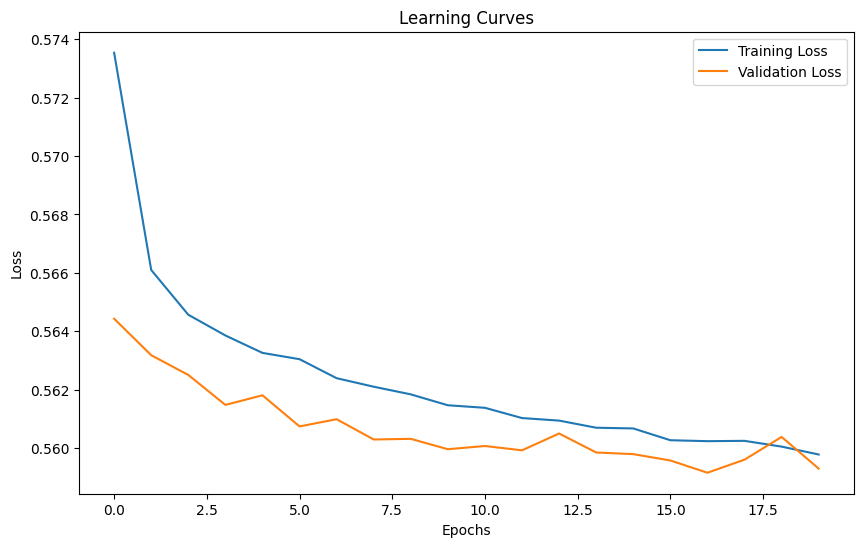

Step 12 (Plot Learning Curves) completed in 0.17 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.07 seconds


In [31]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply Random Oversampling to balance the dataset
start_time = time.time()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_processed, y)
print(f"Step 6 (Random Oversampling) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define a simple neural network with one layer
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\2694128883.py:23: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)
C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\2694128883.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status_binary'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\2694128883.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_l

Epoch 1/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6782 - loss: 0.5887 - val_accuracy: 0.6920 - val_loss: 0.5645
Epoch 2/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6904 - loss: 0.5666 - val_accuracy: 0.6934 - val_loss: 0.5629
Epoch 3/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6922 - loss: 0.5647 - val_accuracy: 0.6951 - val_loss: 0.5615
Epoch 4/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6930 - loss: 0.5634 - val_accuracy: 0.6943 - val_loss: 0.5622
Epoch 5/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6934 - loss: 0.5629 - val_accuracy: 0.6953 - val_loss: 0.5614
Epoch 6/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6937 - loss: 0.5628 - val_accuracy: 0.6958 - val_loss: 0.5608
Epoch 7/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.6944 - loss: 0.5621 - val_accuracy: 0.6957 - val_loss: 0.5606
Epoch 8/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 

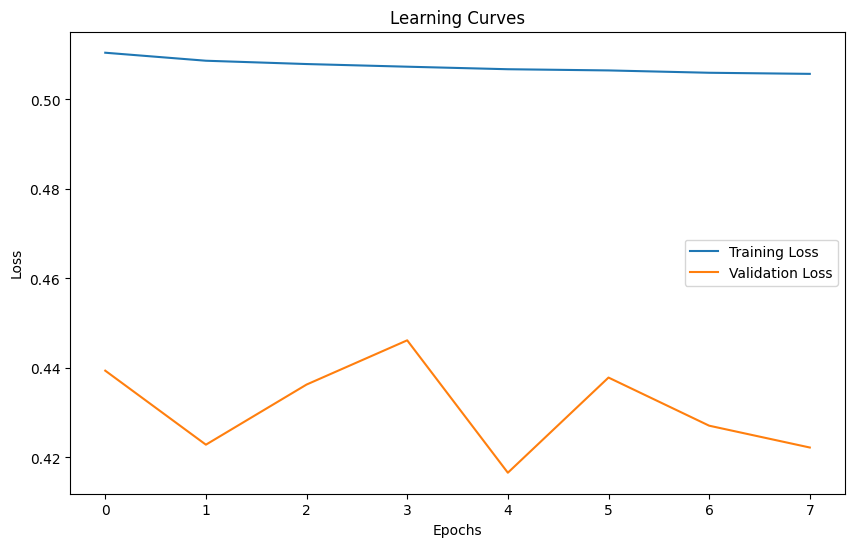

Model saved as 'loan_default_model.h5'


In [2]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)

# Step 2: Filter the target column to include "Fully Paid", "Charged Off", and "Current" loans
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off' or loan_status == 'Current'")

# Mapping the 'loan_status' column to binary labels for "Fully Paid" and "Charged Off" loans
filtered_df['loan_status_binary'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# Step 3: Derive credit history length from 'earliest_cr_line'
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months

# Split the dataset into labeled and unlabeled data
labeled_df = filtered_df.dropna(subset=['loan_status_binary'])
unlabeled_df = filtered_df[filtered_df['loan_status'] == 'Current']

# Step 4: Separate features and target variable
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X_labeled = labeled_df[selected_columns]
y_labeled = labeled_df['loan_status_binary']
X_unlabeled = unlabeled_df[selected_columns]

# Step 5: Preprocess the data
# Identify numerical and categorical columns
numerical_cols = X_labeled.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_labeled.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3
)

# Preprocess labeled and unlabeled data
X_labeled_processed = preprocessor.fit_transform(X_labeled)
X_unlabeled_processed = preprocessor.transform(X_unlabeled)

# Step 6: Apply Random Oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_labeled_processed, y_labeled)

# Step 7: Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Convert sparse matrix to dense if needed
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()
    X_unlabeled_processed = X_unlabeled_processed.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
X_unlabeled_processed = np.array(X_unlabeled_processed)

# Step 8: Train the model from scratch
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Train the initial model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Step 10: Generate pseudo-labels for unlabeled data ("Current" loans)
y_unlabeled_probs = model.predict(X_unlabeled_processed).flatten()
pseudo_labels = (y_unlabeled_probs > 0.5).astype(int)

# Step 11: Add pseudo-labeled data to the training set
X_pseudo_combined = np.vstack((X_train, X_unlabeled_processed))
y_pseudo_combined = np.concatenate((y_train, pseudo_labels))

# Step 12: Balance the dataset after adding pseudo-labeled data
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_pseudo_combined, y_pseudo_combined)

# Step 13: Retrain the model with pseudo-labeled data
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_balanced, y_balanced,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Step 14: Evaluate the final model
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 15: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Step 16: Save the model
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")


C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\3357880382.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 37.28 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\3357880382.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\3357880382.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_17720\3357880382.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Step 2 (Filter Target Column) completed in 2.80 seconds
Step 3 (Derive Credit History Length) completed in 0.18 seconds
Step 4 (Separate Features and Target) completed in 0.12 seconds
Step 5 (Preprocess Data) completed in 6.52 seconds
Step 6 (SMOTE) completed in 3006.16 seconds
Step 7 (Train-Test Split) completed in 1.07 seconds
Step 8 (Convert to Dense) completed in 0.77 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.24 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.6934 - loss: 0.5740 - val_accuracy: 0.7665 - val_loss: 0.4808
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7505 - loss: 0.4948 - val_accuracy: 0.7902 - val_loss: 0.4443
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7685 - loss: 0.4684 - val_accuracy: 0.8009 - val_loss: 0.4255
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7767 - loss: 0.4545 - val_accuracy: 0.8078 - val_loss: 0.4137
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7827 - loss: 0.4460 - val_accuracy: 0.8070 - val_loss: 0.4105
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7866 - loss: 0.4406 - val_accuracy: 0.8137 - val_loss: 0.4040
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7887 - loss: 0.4373 - val_accuracy: 0.8169 - val_loss: 0.4004
Epoch 8/50
1

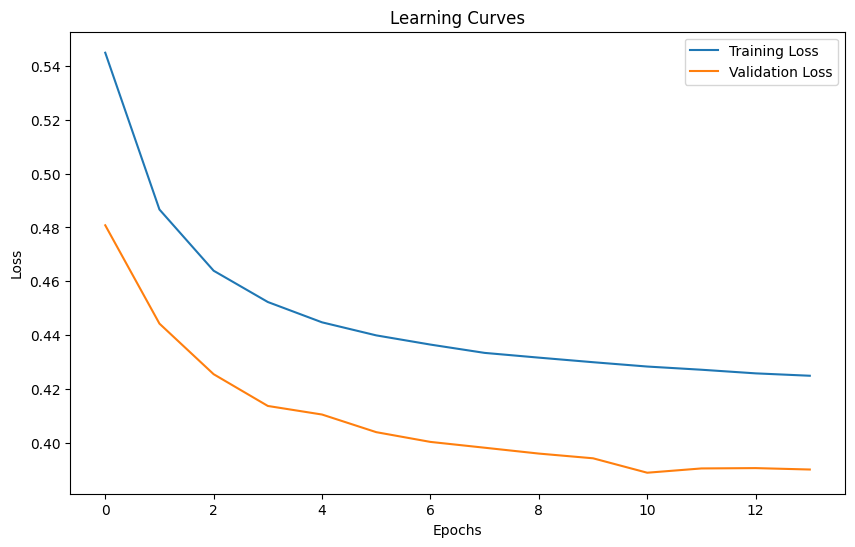

Step 12 (Plot Learning Curves) completed in 0.19 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.08 seconds


In [ ]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply SMOTE to balance the dataset
start_time = time.time()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)
print(f"Step 6 (SMOTE) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define a simple neural network with one layer
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\757402961.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 25.78 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\757402961.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\757402961.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\757402961.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Step 2 (Filter Target Column) completed in 0.99 seconds
Step 3 (Derive Credit History Length) completed in 0.16 seconds
Step 4 (Separate Features and Target) completed in 0.10 seconds
Step 5 (Preprocess Data) completed in 7.14 seconds
Step 6 (SMOTE) completed in 3049.80 seconds
Step 7 (Train-Test Split) completed in 0.89 seconds
Step 8 (Convert to Dense) completed in 0.78 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.38 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6870 - loss: 0.5790 - val_accuracy: 0.7549 - val_loss: 0.4808
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7491 - loss: 0.4872 - val_accuracy: 0.7789 - val_loss: 0.4419
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7678 - loss: 0.4576 - val_accuracy: 0.7877 - val_loss: 0.4291
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7769 - loss: 0.4439 - val_accuracy: 0.7975 - val_loss: 0.4151
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7825 - loss: 0.4348 - val_accuracy: 0.7992 - val_loss: 0.4108
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7874 - loss: 0.4274 - val_accuracy: 0.8054 - val_loss: 0.3995
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7910 - loss: 0.4208 - val_accuracy: 0.8066 - val_loss: 0.3996
Epoch 8/50
1

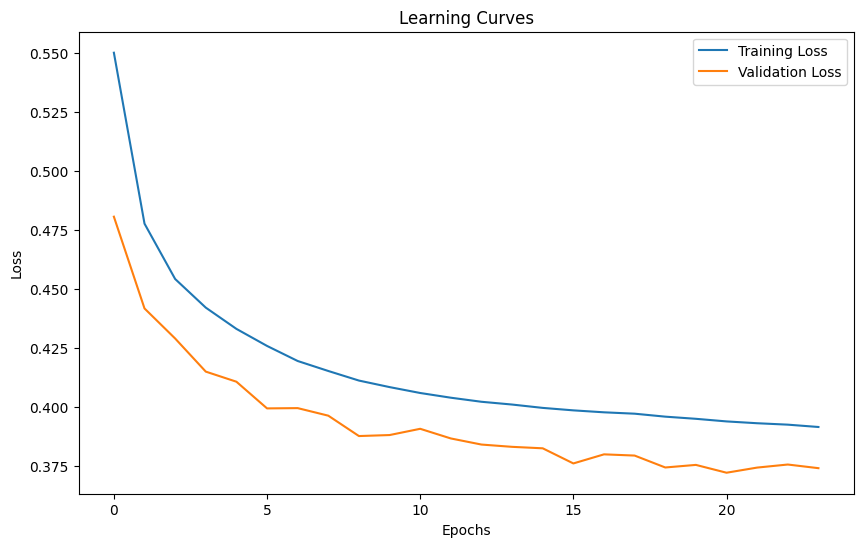

Step 12 (Plot Learning Curves) completed in 0.22 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.06 seconds


In [ ]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply SMOTE to balance the dataset
start_time = time.time()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)
print(f"Step 6 (SMOTE) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define a simple neural network with one layer
start_time = time.time()
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\2941698686.py:24: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)


Step 1 (Load Dataset) completed in 33.23 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\2941698686.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\2941698686.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\2941698686.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Step 2 (Filter Target Column) completed in 1.96 seconds


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\2941698686.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months


Step 3 (Derive Credit History Length) completed in 0.21 seconds
Step 4 (Separate Features and Target) completed in 0.27 seconds
Step 5 (Preprocess Data) completed in 6.70 seconds
Step 6 (SMOTE) completed in 2979.36 seconds
Step 7 (Train-Test Split) completed in 0.99 seconds
Step 8 (Convert to Dense) completed in 0.80 seconds


c:\Users\kosta\Documents\python project\ptyxiaki\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9 (Define Neural Network) completed in 0.45 seconds
Epoch 1/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6808 - loss: 0.5907 - val_accuracy: 0.7575 - val_loss: 0.4770
Epoch 2/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7497 - loss: 0.4886 - val_accuracy: 0.7778 - val_loss: 0.4397
Epoch 3/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7698 - loss: 0.4554 - val_accuracy: 0.7939 - val_loss: 0.4205
Epoch 4/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7819 - loss: 0.4368 - val_accuracy: 0.8020 - val_loss: 0.4039
Epoch 5/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7887 - loss: 0.4263 - val_accuracy: 0.8054 - val_loss: 0.3998
Epoch 6/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7930 - loss: 0.4188 - val_accuracy: 0.8087 - val_loss: 0.3927
Epoch 7/50
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7961 - loss: 0.4128 - val_accuracy: 0.8130 - val_loss: 0.3849
Epoch 8/50
1

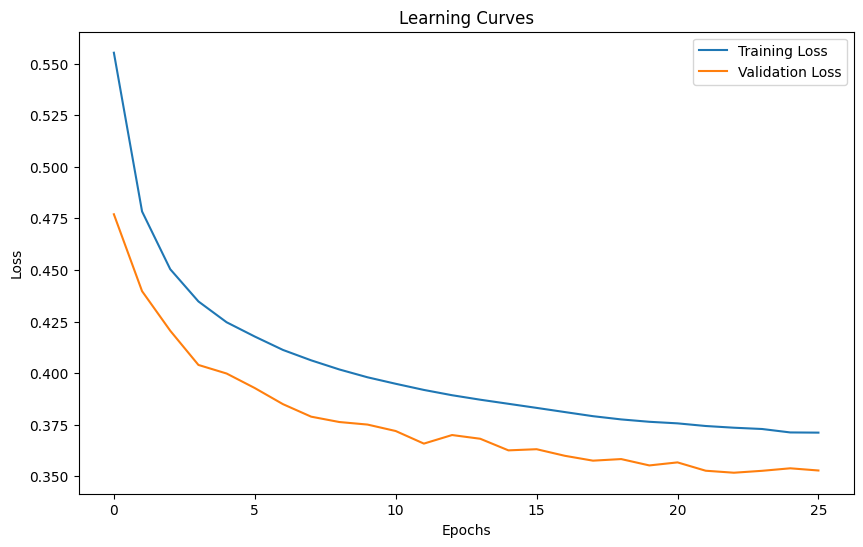

Step 12 (Plot Learning Curves) completed in 0.20 seconds
Model saved as 'loan_default_model.h5'
Step 13 (Save Model) completed in 0.10 seconds


In [2]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
start_time = time.time()
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)
print(f"Step 1 (Load Dataset) completed in {time.time() - start_time:.2f} seconds")

# Step 2: Filter the target column to focus on "Fully Paid" and "Charged Off" loans
start_time = time.time()
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")

# Mapping the 'loan_status' column to binary labels
filtered_df['loan_status'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print(f"Step 2 (Filter Target Column) completed in {time.time() - start_time:.2f} seconds")

# Step 3: Derive credit history length from 'earliest_cr_line'
start_time = time.time()
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months
print(f"Step 3 (Derive Credit History Length) completed in {time.time() - start_time:.2f} seconds")

# Step 4: Separate features and target variable
start_time = time.time()
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X = filtered_df[selected_columns]
y = filtered_df['loan_status']
print(f"Step 4 (Separate Features and Target) completed in {time.time() - start_time:.2f} seconds")

# Step 5: Preprocess the data
start_time = time.time()
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3  # Keep sparse representation if less than 30% dense
)

# Preprocess data
X_processed = preprocessor.fit_transform(X)
print(f"Step 5 (Preprocess Data) completed in {time.time() - start_time:.2f} seconds")

# Step 6: Apply SMOTE to balance the dataset
start_time = time.time()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)
print(f"Step 6 (SMOTE) completed in {time.time() - start_time:.2f} seconds")

# Step 7: Split the data with stratification
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"Step 7 (Train-Test Split) completed in {time.time() - start_time:.2f} seconds")

# Convert sparse matrix to dense if needed
start_time = time.time()
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f"Step 8 (Convert to Dense) completed in {time.time() - start_time:.2f} seconds")

# Step 9: Define a simple neural network with one layer
start_time = time.time()
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"Step 9 (Define Neural Network) completed in {time.time() - start_time:.2f} seconds")

# Step 10: Train the model
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)
print(f"Step 10 (Train Model) completed in {time.time() - start_time:.2f} seconds")

# Step 11: Evaluate the model
start_time = time.time()
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(f"Step 11 (Evaluate Model) completed in {time.time() - start_time:.2f} seconds")

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 12: Plot learning curves
start_time = time.time()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
print(f"Step 12 (Plot Learning Curves) completed in {time.time() - start_time:.2f} seconds")

# Step 13: Save the model
start_time = time.time()
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
print(f"Step 13 (Save Model) completed in {time.time() - start_time:.2f} seconds")


C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\697595867.py:23: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name)
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\697595867.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loan_status_binary'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
C:\Users\kosta\AppData\Local\Temp\ipykernel_16836\697595867.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['credit_history_leng

Epoch 1/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.6915 - loss: 0.5779 - val_accuracy: 0.7588 - val_loss: 0.4860
Epoch 2/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7495 - loss: 0.4976 - val_accuracy: 0.7896 - val_loss: 0.4420
Epoch 3/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7674 - loss: 0.4694 - val_accuracy: 0.7979 - val_loss: 0.4294
Epoch 4/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7755 - loss: 0.4572 - val_accuracy: 0.8045 - val_loss: 0.4168
Epoch 5/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7803 - loss: 0.4496 - val_accuracy: 0.8126 - val_loss: 0.4103
Epoch 6/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7842 - loss: 0.4442 - val_accuracy: 0.8122 - val_loss: 0.4047
Epoch 7/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7863 - loss: 0.4405 - val_accuracy: 0.8161 - val_loss: 0.4012
Epoch 8/20
10205/10205 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 

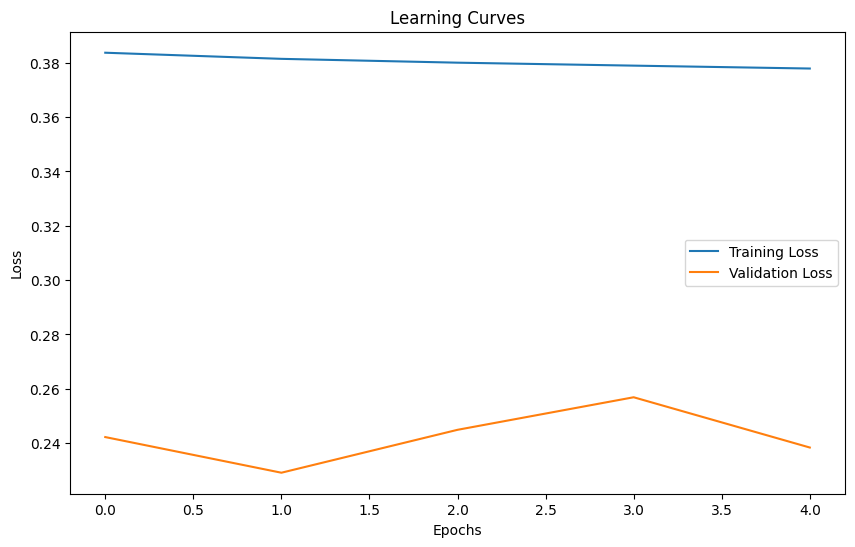

Model saved as 'loan_default_model.h5'


: 

In [ ]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time

# Step 1: Extract and load the dataset
csv_file_name = r"C:\Users\kosta\Downloads\accepted (2).csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_name)

# Step 2: Filter the target column to include "Fully Paid", "Charged Off", and "Current" loans
filtered_df = df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off' or loan_status == 'Current'")

# Mapping the 'loan_status' column to binary labels for "Fully Paid" and "Charged Off" loans
filtered_df['loan_status_binary'] = filtered_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# Step 3: Derive credit history length from 'earliest_cr_line'
filtered_df['credit_history_length'] = pd.to_datetime('today') - pd.to_datetime(filtered_df['earliest_cr_line'], errors='coerce')
filtered_df['credit_history_length'] = filtered_df['credit_history_length'].dt.days // 30  # Convert to months

# Split the dataset into labeled and unlabeled data
labeled_df = filtered_df.dropna(subset=['loan_status_binary'])
unlabeled_df = filtered_df[filtered_df['loan_status'] == 'Current']

# Step 4: Separate features and target variable
selected_columns = [
    'annual_inc', 'credit_history_length', 'delinq_2yrs', 'dti', 'emp_length',
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership',
    'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
    'mths_since_last_delinq', 'open_acc', 'purpose', 'pub_rec', 'revol_bal',
    'revol_util', 'sub_grade', 'term', 'total_acc', 'total_rec_late_fee', 'verification_status',
    'collections_12_mths_ex_med', 'mths_since_last_record', 'debt_settlement_flag'
]
X_labeled = labeled_df[selected_columns]
y_labeled = labeled_df['loan_status_binary']
X_unlabeled = unlabeled_df[selected_columns]

# Step 5: Preprocess the data
# Identify numerical and categorical columns
numerical_cols = X_labeled.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_labeled.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    sparse_threshold=0.3
)

# Preprocess labeled and unlabeled data
X_labeled_processed = preprocessor.fit_transform(X_labeled)
X_unlabeled_processed = preprocessor.transform(X_unlabeled)

# Step 6: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_labeled_processed, y_labeled)

# Step 7: Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Convert sparse matrix to dense if needed
if hasattr(X_train, "todense"):
    X_train = X_train.todense()
    X_test = X_test.todense()
    X_unlabeled_processed = X_unlabeled_processed.todense()

# Convert to numpy arrays for compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
X_unlabeled_processed = np.array(X_unlabeled_processed)

# Step 8: Train the model from scratch
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Train the initial model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Step 10: Generate pseudo-labels for unlabeled data ("Current" loans)
y_unlabeled_probs = model.predict(X_unlabeled_processed).flatten()
pseudo_labels = (y_unlabeled_probs > 0.5).astype(int)

# Step 11: Add pseudo-labeled data to the training set
X_pseudo_combined = np.vstack((X_train, X_unlabeled_processed))
y_pseudo_combined = np.concatenate((y_train, pseudo_labels))

# Step 12: Balance the dataset after adding pseudo-labeled data
X_balanced, y_balanced = smote.fit_resample(X_pseudo_combined, y_pseudo_combined)

# Step 13: Retrain the model with pseudo-labeled data
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_balanced, y_balanced,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Step 14: Evaluate the final model
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

# Step 15: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Step 16: Save the model
model.save('loan_default_model.h5')
print("Model saved as 'loan_default_model.h5'")
